In [1]:
import pandas as pd
from math import isnan
import requests
import json
from bs4 import BeautifulSoup as BS
from time import sleep
from numpy.random import randint
import numpy as np

# step 1 - downloading voting data

First I'll load my flat file into a dataframe.

In [2]:
df = pd.read_csv('votes_by_county_2012_2016.csv')

Let's have a look at the head of the file.

In [3]:
df.head(3)

,Unnamed: 0,combined_fips,votes_dem_2016,votes_gop_2016,total_votes_2016,per_dem_2016,per_gop_2016,diff_2016,per_point_diff_2016,state_abbr,...,FIPS,total_votes_2012,votes_dem_2012,votes_gop_2012,county_fips,state_fips,per_dem_2012,per_gop_2012,diff_2012,per_point_diff_2012
0,0,2013,93003.0,130413.0,246588.0,0.377159,0.52887,37410,-0.151711,AK,...,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2016,93003.0,130413.0,246588.0,0.377159,0.52887,37410,-0.151711,AK,...,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2020,93003.0,130413.0,246588.0,0.377159,0.52887,37410,-0.151711,AK,...,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It doesn't look good. There are identical values in multiple rows where there shouldn't be, and lots of missing entries. Let's find all the rows with missing values.

In [4]:
df[df.isnull().any(axis=1)]

,Unnamed: 0,combined_fips,votes_dem_2016,votes_gop_2016,total_votes_2016,per_dem_2016,per_gop_2016,diff_2016,per_point_diff_2016,state_abbr,...,FIPS,total_votes_2012,votes_dem_2012,votes_gop_2012,county_fips,state_fips,per_dem_2012,per_gop_2012,diff_2012,per_point_diff_2012
0,0,2013,93003.0,130413.0,246588.0,0.377159,0.52887,37410,-0.151711,AK,...,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2016,93003.0,130413.0,246588.0,0.377159,0.52887,37410,-0.151711,AK,...,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2020,93003.0,130413.0,246588.0,0.377159,0.52887,37410,-0.151711,AK,...,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2050,93003.0,130413.0,246588.0,0.377159,0.52887,37410,-0.151711,AK,...,2050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2060,93003.0,130413.0,246588.0,0.377159,0.52887,37410,-0.151711,AK,...,2060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,2068,93003.0,130413.0,246588.0,0.377159,0.52887,37410,-0.151711,AK,...,2068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,2070,93003.0,130413.0,246588.0,0.377159,0.52887,37410,-0.151711,AK,...,2070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,2090,93003.0,130413.0,246588.0,0.377159,0.52887,37410,-0.151711,AK,...,2090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,2100,93003.0,130413.0,246588.0,0.377159,0.52887,37410,-0.151711,AK,...,2100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,2105,93003.0,130413.0,246588.0,0.377159,0.52887,37410,-0.151711,AK,...,2105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The good news is only Alaska is missing data. I can fix it. The FIPS numbers are present, which will allow me to match these up with a list of Alaska counties [here](https://en.wikipedia.org/wiki/List_of_boroughs_and_census_areas_in_Alaska).

In [5]:
# Reading in the Alaska county FIPS data
ak_co = pd.read_csv("alaska_counties.csv")

# Recoding the FIPS code column as string type
ak_co['FIPS code'] = ak_co['FIPS code'].astype(str)

# Identifying the columns with FIPS code length 2 and 3
mask2 = ak_co['FIPS code'].str.len() == 2
mask3 = ak_co['FIPS code'].str.len() == 3

# Setting the FIPS column with padding matching the county FIPS code length
ak_co.loc[mask2,'FIPS']='20'+ak_co.loc[mask2,'FIPS code'].astype(str)
ak_co.loc[mask3,'FIPS']='2'+ak_co.loc[mask3,'FIPS code'].astype(str)

# Recode the Alaska counties dataframe FIPS column as integers (necessary for the join)
ak_co['FIPS']=ak_co['FIPS'].astype(int)

# Join df and ak_co on FIPS
df=df.set_index('FIPS').join(ak_co.set_index('FIPS'))

# The joining deleted FIPS as a column, so I reconstitute it for reference purposes.
df['FIPS'] = df.index

Let's see if we missed any counties. We'll check for Alaska counties with NaN for the Borough.

In [6]:
df.loc[(df['state_abbr']=='AK') & (df['Borough'].isnull())]

,Unnamed: 0,combined_fips,votes_dem_2016,votes_gop_2016,total_votes_2016,per_dem_2016,per_gop_2016,diff_2016,per_point_diff_2016,state_abbr,...,votes_gop_2012,county_fips,state_fips,per_dem_2012,per_gop_2012,diff_2012,per_point_diff_2012,Borough,FIPS code,FIPS
FIPS,,,,,,,,,,,,,,,,,,,,,
2261,24,2261,93003.0,130413.0,246588.0,0.377159,0.52887,37410,-0.151711,AK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2261
2270,25,2270,93003.0,130413.0,246588.0,0.377159,0.52887,37410,-0.151711,AK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2270


There are two Boroughs which are left blank due to name changes since the election data was gathered. These correspond to FIPS codes 2261 and 2270. They'll need to be filled in manually.

In [7]:
df.loc[2261,'Borough']='Valdez-Cordova'
df.loc[2270,'Borough']='Wade Hampton'

Next we set the county_name column to the Borough name for those rows with a nonnull Borough (i.e. the Alaska rows). 

In [8]:
df.loc[(df['Borough'].notnull()),'county_name']=df['Borough']

Now we're done with the columns joined from the Alaska counties dataframe, so we can drop them.

In [9]:
df = df.drop(columns=['Borough', 'FIPS code'])

Now we need the county-level vote information for the Alaska boroughs. I found the data [here](https://rrhelections.com/index.php/2018/02/02/alaska-results-by-county-equivalent-1960-2016/). I'll load it and attach it to the main dataframe.

In [10]:
ak_votes = pd.read_csv('alaska_votes.csv')

In [11]:
df=df.join(ak_votes.set_index('combined_fips'),rsuffix='_add')

Next I'll plug the attached Alaska voting data into the corresponding columns of the main dataframe.

In [12]:
ak_vote_info_headers = ['total_votes_2016','per_dem_2016','per_gop_2016','total_votes_2012','per_dem_2012','per_gop_2012']
for header in ak_vote_info_headers:
    df.loc[df['state_abbr']=='AK',header]=df[header+'_add']

We're done with the joined columns and can now drop them.

In [13]:
ak_vote_info_headers_add = [header+'_add' for header in ak_vote_info_headers]
df = df.drop(columns = ak_vote_info_headers_add)

Some of the columns need to be computed from the imported AK data.

In [14]:
df.loc[df['state_abbr']=='AK','votes_dem_2016']=round(df['total_votes_2016']*df['per_dem_2016'])
df.loc[df['state_abbr']=='AK','votes_gop_2016']=round(df['total_votes_2016']*df['per_gop_2016'])
df.loc[df['state_abbr']=='AK','votes_dem_2012']=round(df['total_votes_2016']*df['per_dem_2012'])
df.loc[df['state_abbr']=='AK','votes_gop_2012']=round(df['total_votes_2016']*df['per_gop_2012'])
df.loc[df['state_abbr']=='AK','per_point_diff_2016']=abs(df['per_dem_2016']-df['per_gop_2016'])
df.loc[df['state_abbr']=='AK','per_point_diff_2012']=abs(df['per_dem_2012']-df['per_gop_2012'])
df.loc[df['state_abbr']=='AK','diff_2016']=abs(df['votes_dem_2016']-df['votes_gop_2016'])
df.loc[df['state_abbr']=='AK','diff_2012']=abs(df['votes_dem_2012']-df['votes_gop_2012'])

The state_fips and county_fips columns need to be filled in, and then we have finished repairing the AK data.

In [15]:
df.loc[df['state_abbr']=='AK','state_fips']=2
df.loc[df['state_abbr']=='AK','county_fips']=df['FIPS']-2000

It's inconsistent that the difference columns for the raw vote totals are computed as an absolute value, but the percentage difference columns are computed as dem - gop. I correct the inconsistency by recoding the latter.

In [16]:
df['per_point_diff_2016']=abs(df['per_point_diff_2016'])
df['per_point_diff_2012']=abs(df['per_point_diff_2012'])

I rename columns for clarity and consistency, and clean up the index.

In [17]:
new_col_names = df.columns.values
new_col_names[0] = 'index'
new_col_names[5] = 'pct_dem_2016'
new_col_names[6] = 'pct_gop_2016'
new_col_names[7] = 'abs_raw_diff_2016'
new_col_names[8] = 'abs_pct_diff_2016'
new_col_names[16] = 'pct_dem_2012'
new_col_names[17] = 'pct_gop_2012'
new_col_names[18] = 'abs_raw_diff_2012'
new_col_names[19] = 'abs_pct_diff_2012'
new_col_names[20] = 'fips'
df.columns = new_col_names
df.index = df['index']
df = df.drop(columns = ['index'])

And now the dataset is ready to go!

In [18]:
df

,combined_fips,votes_dem_2016,votes_gop_2016,total_votes_2016,pct_dem_2016,pct_gop_2016,abs_raw_diff_2016,abs_pct_diff_2016,state_abbr,county_name,total_votes_2012,votes_dem_2012,votes_gop_2012,county_fips,state_fips,pct_dem_2012,pct_gop_2012,abs_raw_diff_2012,abs_pct_diff_2012,fips
index,,,,,,,,,,,,,,,,,,,,
0,2013,172.0,305.0,547.0,0.315000,0.558000,133.0,0.243000,AK,Aleutians East Borough,549.0,233.0,291.0,13.0,2.0,0.426000,0.532000,58.0,0.106000,2013
1,2016,699.0,404.0,1227.0,0.570000,0.329000,295.0,0.241000,AK,Aleutians West Census Area,1239.0,771.0,422.0,16.0,2.0,0.628000,0.344000,349.0,0.284000,2016
2,2020,54395.0,61473.0,131072.0,0.415000,0.469000,7078.0,0.054000,AK,Anchorage Municipality,125169.0,56623.0,69468.0,20.0,2.0,0.432000,0.530000,12845.0,0.098000,2020
3,2050,2719.0,1103.0,4944.0,0.550000,0.223000,1616.0,0.327000,AK,Bethel Census Area,4711.0,3520.0,1182.0,50.0,2.0,0.712000,0.239000,2338.0,0.473000,2050
4,2060,139.0,274.0,464.0,0.300000,0.591000,135.0,0.291000,AK,Bristol Bay Borough,426.0,161.0,274.0,60.0,2.0,0.346000,0.591000,113.0,0.245000,2060
5,2068,395.0,589.0,1113.0,0.355000,0.529000,194.0,0.174000,AK,Denali Borough,923.0,491.0,572.0,68.0,2.0,0.441000,0.514000,81.0,0.073000,2068
6,2070,992.0,660.0,1908.0,0.520000,0.346000,332.0,0.174000,AK,Dillingham Census Area,1639.0,1126.0,689.0,70.0,2.0,0.590000,0.361000,437.0,0.229000,2070
7,2090,13589.0,22196.0,41180.0,0.330000,0.539000,8607.0,0.209000,AK,Fairbanks North Star Borough,40539.0,14948.0,24131.0,90.0,2.0,0.363000,0.586000,9183.0,0.223000,2090
8,2100,738.0,674.0,1655.0,0.446000,0.407000,64.0,0.039000,AK,Haines Borough,1310.0,751.0,789.0,100.0,2.0,0.454000,0.477000,38.0,0.023000,2100


In [19]:
df.to_csv('df_votes.csv',index = False)

# step 2 - scraping citydata

First I will get the data containing the county name, state, FIPS, coordinates, and other information.

In [2]:
''' Getting the county lat/long coordinates info from wikipedia. These will be needed
    for the weather API calls.
'''

# Getting the html data for the county coordinates table
url = 'https://en.wikipedia.org/wiki/User:Michael_J/County_table'
r = requests.get(url)
soup = BS(r.content, "lxml")

# Parsing the data into a list
counties_headers = soup.find('tbody').find_all('tr')[0].text.split('\n')
counties_lst = []
table_rows = soup.find('tbody').find_all('tr')
table_len = len(soup.find('tbody').find_all('tr'))
for i in range(1,table_len):
    row_info = table_rows[i].text.split('\n')
    row_info[13]=row_info[13][1:-1]
    row_info[14]=row_info[14][1:-1]
    counties_lst.append(row_info)
    
# Converting the list to a dataframe and adding headers
counties_df = pd.DataFrame(counties_lst)
counties_df.columns = counties_headers

In [3]:
counties_df.head()

,,Sort [1],State,FIPS,County [2],County Seat(s) [3],Population(2010),Land Areakm²,Land Areami²,Water Areakm²,Water Areami²,Total Areakm²,Total Areami²,Latitude,Longitude,
0,,1,AL,01001,Autauga,Prattville,"54,571","1,539.582",594.436,25.776,9.952,"1,565.358",604.388,32.536382,86.644490,
1,,2,AL,01003,Baldwin,Bay Minette,"182,265","4,117.522","1,589.784","1,133.190",437.527,"5,250.712","2,027.311",30.659218,87.746067,
2,,3,AL,01005,Barbour,Clayton,"27,457","2,291.819",884.876,50.865,19.639,"2,342.684",904.515,31.870670,85.405456,
3,,4,AL,01007,Bibb,Centreville,"22,915","1,612.481",622.582,9.289,3.587,"1,621.770",626.169,33.015893,87.127148,
4,,5,AL,01009,Blount,Oneonta,"57,322","1,669.962",644.776,15.157,5.852,"1,685.119",650.628,33.977448,86.567246,


The first column is just the sort number which is redundant with the index, so I'll drop it.

In [4]:
# Operation 1: Remove a redundant column

counties_df = counties_df.iloc[:,2:15]

 I'll clean up the county names column, as some of the names have extraneous bracketed integers appended. A few counties in MD and HI have apostrophes or another special character in the name, which the URL format for citydata does not make use of. So I'll remove those as well.

In [5]:
# Operation 2: Cleaning up the County column

for index,row in counties_df.iterrows():
    if '[' in row['County [2]']:
        counties_df.at[index,'County [2]']=row['County [2]'].split('[')[0][:-1]

def remove_apos(x):
    return(x.replace('ʻ','').replace("'",''))

counties_df['County [2]']=counties_df['County [2]'].apply(remove_apos)

The columns all consist of strings, but some of the columns are numeric and should be converted accordingly. Before converting the strings to float, I need to remove the commas.

In [6]:
def decomma(string):
    return(string.replace(',',''))

def to_num_gen(string, mode = 'float'):
    if type(string)!=str:
        return(string)
    if mode=='float':
        try:
            return(float(decomma(string)))
        except:
            pass
    elif mode =='int':
        return(int(decomma(string)))

c = list(counties_df.columns)
    
# Columns 1 and 4 contain integers
for col in [c[1], c[4]]:    
    counties_df[col] = counties_df[col].apply(to_num_gen, mode = 'int')  
    
# Columns 5, 6, 7, 8, 9, 10, 11, and 12 contain floats
for col in [c[5], c[6], c[7], c[8], c[9], c[10], c[11], c[12]]:    
    counties_df[col] = counties_df[col].apply(to_num_gen)
    
# We lost the negative on the longitude, so I'll add it back in.
counties_df['Longitude']=counties_df['Longitude'].apply(lambda x:-x)

Now I turn to scraping data from citydata. I'll define some helper functions first.

In [7]:
def find_line(lst,string):
    '''Returns the position in lst in which string first occurs.
       If the search fails, returns None.
    '''
    count = 0
    for item in lst:
        if string in item:
            return(count)
        count += 1
    return(None)

In [8]:
def row_slice(string, n, bound_1, bound_2, direction = 1):
    '''Accepts: a string to search, int, two string bounds

       Returns: extraction of string from the nth instance of bound_1 to
       the first instance of bound_2, exclusive. If direction = 1, operates
       left to right; if direction = -1, operates from right to left.
    '''
    if direction == 1:
        return string.split(bound_1)[n].split(bound_2)[0]
    if direction == -1:
        k = len(string.split(bound_1))
        string2 = string.split(bound_1)[k-n-1]
        return string2.split(bound_1)[-1]

In [9]:
def get_data(dct,var,string,i,occur,bound_1,bound_2,direction=1):
    ''' For reducing repetition of code in the extract_data_from_html function, I
        put the try/except block used to populate each dictionary value here.
        Accepts:
            dct = the city's data dictionary
            var = the dictionary key whose value is being sought
            string, i, occur, bound_1, bound_2, direction = arguments of row_slice
        Returns:
            None
        Side effects:
            updates dct[var] with the found value, or np.nan if there is an error
    '''
    try:
        dct[var] = row_slice(string[i],occur,bound_1,bound_2,direction)
    except:
        dct[var] = np.nan

In [10]:
def extract_data_from_html(soup, fips, county, state):
    '''Accepts: BeautifulSoup html from a city-data county web page
       Returns: a dict containing the relevant county data.
    '''
    dct = {'fips':fips,'county':county,'state':state}
    
    # Population numbers, reference years, and percent urban
    try:
        row = [soup.find(id="population").text]
        get_data(dct,'pop_ref_later_year',row,0,1,' in ',':')
        get_data(dct,'pop_in_later_year',row,0,1,' was ',' ')
        get_data(dct,'pop_ref_earlier_year',row,0,2,' in ','<')
        get_data(dct,'pop_in_earlier_year',row,0,1,' was ',' ')
        get_data(dct,'pop_percent_urban',row,0,1,'(','%')
    except:
        for key in ['pop_ref_later_year','pop_in_later_year','pop_ref_earlier_year',
                   'pop_in_earlier_year','pop_percent_urban']:
            dct[key] = np.nan

    # Number of married couples with children
    try:
        row = soup.find(id="household-types").text.split('\n')
        i = find_line(row,'married couples with children')
        dct['mar_coup_w_children'] = row[i].split(' ')[0]
    except: dct['mar_coup_w_children'] = np.nan

    # Population per square mile
    try:
        row = soup.find(id="population-density").text.split('\n')
        i = find_line(row,'people per square mile')
        get_data(dct,'pop_per_sq_mi',row,i,1,': ',' ')
    except: dct['pop_per_sq_mi']=np.nan
    
    # Cost of living reference year and index
    try:
        row = soup.find(id="cost-of-living").text.split('\n')
        i = find_line(row,'cost of living in')
        get_data(dct,'cost_of_living_yr',row,i,1,' ',' ')
        get_data(dct,'cost_of_living',row,i,1,': ',' ')
    except:
        dct['cost_of_living_yr']=np.nan
        dct['cost_of_living']=np.nan

    # Median age
    try:
        row = soup.find(id="median-age").text.split('\n')
        i = find_line(row,'Median resident age:')
        get_data(dct,'median_age',row,i,1,':',' ')
    except:
        dct['median_age']=np.nan

    # Population numbers by sex
    try:
        row = soup.find(id="population-by-sex").text.split('\n')
        i = find_line(row,'Males:')
        dct['pop_m'] = row_slice(row[i].replace('\xa0',' '),1,'Males: ',' ')
        dct['pop_f'] = row_slice(row[i].replace('\xa0',' '),1,'Females: ',' ')
    except:
        dct['pop_m'] = np.nan
        dct['pop_f'] = np.nan

    # Median age by gender
    try:
        row = soup.find(id="poverty").text.split('\n')
        i = find_line(row,'Males:')
        get_data(dct,'median_age_m',row,i,1,'Males: ',' ')
        get_data(dct,'median_age_f',row,i,1,'Females: ',' ')
    except:
        dct['median_age_m']=np.nan
        dct['median_age_f']=np.nan

    # Median household income, year, and reference value and year
    try:
        row = soup.find(id="household-prices").text.split('\n')
        i = find_line(row,'Estimated median household income in')
        get_data(dct,'median_house_inc_yr',row,i,1,' in ',':')
        get_data(dct,'median_house_inc_val',row,i,1,'$',' ')
        get_data(dct,'median_house_inc_ref_yr',row,i,2,' in ',')')
        get_data(dct,'median_house_inc_ref_val',row,i,2,'$',' ')
    except:
        dct['median_house_inc_yr']=np.nan
        dct['median_house_inc_val']=np.nan
        dct['median_house_inc_ref_yr']=np.nan
        dct['median_house_inc_ref_val']=np.nan

    # Average household size
    try:
        row = soup.find(id="household-prices").text.split('\n')
        i = find_line(row,'County:')
        get_data(dct,'avg_household_size',row,i,1,':',' ')
    except:
        dct['avg_household_size']=np.nan
        
    # Estimated median house/condo value, year, and reference value and year
    try:
        row = soup.find(id="household-prices").text.split('\n')
        i = find_line(row,'Estimated median house or condo value in')
        get_data(dct,'median_house_value_yr',row,i,1,' in ',':')
        get_data(dct,'median_house_value_val',row,i,1,'$',' ')
        get_data(dct,'median_house_value_ref_yr',row,i,2,' in ',')')
        get_data(dct,'median_house_value_ref_yr_val',row,i,2,'$',' ')
    except:
        dct['median_house_value_yr']=np.nan
        dct['median_house_value_val']=np.nan
        dct['median_house_value_ref_yr']=np.nan
        dct['median_house_value_ref_yr_val']=np.nan

    # Percentage living in poverty
    try:
        row = soup.find(id="poverty").text.split('\n')
        i = find_line(row,'Percentage of residents living in poverty in')
        get_data(dct,'poverty_pct',row,i,1,': ','%')
    except:    
        dct['poverty_pct']=np.nan

    # Fair market rental costs
    try:
        row = soup.find(id="rents").text.split('\n')
        for j in ['1','2','3']:
            i = find_line(row,'for a {}-bedroom apartment'.format(j))
            get_data(dct,'rent_{}br'.format(j),row,i,1,'$',' ')
    except:
        for j in ['1','2','3']:
            dct['rent_{}br']=np.nan

    # Unemployment year and rate
    try:
        row = soup.find(id="unemployment").text.split('\n')
        i = find_line(row,'Unemployment in')
        dct['unemp_date'] = row_slice(row[i],1,':',' ',-1).split(' ')[-1]
        i = find_line(row,'%')
        get_data(dct,'unemp_rate',row,i,1,'Here:','%')
    except:
        dct['unemp_date'] = np.nan
        dct['unemp_rate'] = np.nan

    # Foreign born population
    try:
        row = soup.find(id="foreign-born-population").text.split('\n')
        i = find_line(row,'Number of foreign born residents:')
        get_data(dct,'pop_foreign_born',row,i,1,': ',' ')
    except:    
        dct['pop_foreign_born']=np.nan

    # Mean commute time
    try:
        row = soup.find(id="commute").text.split('\n')
        i = find_line(row,'Mean travel time to work (commute):')
        get_data(dct,'commute_minutes',row,i,1,': ',' ')
    except:    
        dct['commute_minutes']=np.nan

    # Adult obesity rate
    try:
        row = soup.find(id="food-environment").text.split('\n')
        i = find_line(row,'Adult obesity rate')
        get_data(dct,'adult_obes_rate',row,i,2,':','%')
        i = find_line(row,'Low-income preschool obesity rate')
        get_data(dct,'presch_obes_rate',row,i,2,':','%')
    except:    
        dct['adult_obes_rate']=np.nan
        dct['presch_obes_rate']=np.nan

    # Average farm size (acres)
    try:
        row = soup.find(id="agriculture").text.split('\n')
        i = find_line(row,'Average size of farms:')
        get_data(dct,'avg_farm_size',row,i,1,': ',' ')

        # Average total agricultural sales per farm
        i = find_line(row,'Average value of agricultural products sold')
        get_data(dct,'avg_farm_sales',row,i,1,'$',' ')

        # Average farm value of machinery
        i = find_line(row,'Average market value of all machinery')
        get_data(dct,'avg_farm_mach_val',row,i,1,'$',' ')

        # Percent of farms family-owned and -operated
        i = find_line(row,'percentage of farms operated by a family or individual')
        get_data(dct,'pct_farms_fam_op',row,i,1,': ','%')
    except:
        dct['avg_farm_size']=np.nan
        dct['avg_farm_sales']=np.nan
        dct['avg_farm_mach_val']=np.nan
        dct['pct_farms_fam_op']=np.nan
        
    # Birth rates per pop, inc reference value and interval
    try:
        row = soup.find(id="births-deaths").text.split('\n')
        i = find_line(row,'Births per 1000 population from 1')
        get_data(dct,'births_from_yr_int1',row,i,1,' from ',' ')
        get_data(dct,'births_to_yr_int1',row,i,1,' to ',':')
        dct['birth_per_1000_int1'] = row[i].split(' ')[-1]
        i = find_line(row,'Births per 1000 population from 2')
        get_data(dct,'births_from_yr_int2',row,i,1,' from ',' ')
        get_data(dct,'births_to_yr_int2',row,i,1,' to ',':')
        dct['birth_per_1000_int2'] = row[i].split(' ')[-1]
    except:
        dct['birth_per_1000_int2'] = np.nan
        dct['birth_per_1000_int1'] = np.nan

    return(dct)

In [11]:
# Setting agent headers for the scraping
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36'}

def scrape_citydata(counties_df):
    '''The first run at scraping the county info from citydata, taking county and state
       names from the counties_df dataframe and guessing at URLs. Most follow a general
       pattern, but some will fail and need to be reworked manually. Any valid URLs for
       which the extraction function hits an unhandled exception go into their own list
       for retrying.
       
       Accepts: A dataframe containing county names
       Returns: A list of dictionaries containing county data
    '''
    failed_valid_url = []
    failed_invalid_url = []
    retrieved_data = []
    counties = counties_df['County [2]']
    states = counties_df['State']
    fips = counties_df['FIPS']
    for (fips,county,state) in list(zip(fips.values,counties.values,states.values)):
        county=county.replace(' ','_')
        url = 'http://www.city-data.com/county/{}_County-{}.html\n'.format(county,state)
        try:
            r = requests.get(url, headers = headers)
            soup = BS(r.content, "lxml")
            dct = extract_data_from_html(soup, fips, county, state)         
            retrieved_data.append(dct)
        except:
            if r.status_code == 200:
                failed_valid_url.append((fips,county,state,url))
            else:
                failed_invalid_url.append((fips,county,state,url))
        sleep(randint(10,25)) # Sleep, so as to not scandalize the web server
    return(retrieved_data, failed_valid_url, failed_invalid_url)

In [12]:
# Conduct the first round of scraping
county_dct_lst,failed_valid_url,failed_invalid_url = scrape_citydata(counties_df)

# Convert the list of dictionaries obtained so far into a dataframe
df=pd.DataFrame.from_dict(county_dct_lst)

All of the AK counties failed with error code 404 because they are not called counties. They are called buroughs or census areas. I had to manually look up the URLs. Similarly for VA: many of the county URLs violate the format used for the other 48 states, so I reworked them by hand.

In [13]:
reworked_urls = [(2013,'Aleutians_East_Borough','AK',
                     'http://www.city-data.com/county/Aleutians_East_Borough-AK.html'),
                 (2020,'Anchorage','AK','http://www.city-data.com/county/Anchorage_Municipality-AK.html'),
                 (2050,'Bethel','AK','http://www.city-data.com/county/Bethel_Census_Area-AK.html'),
                 (2060,'Bristol Bay','AK','http://www.city-data.com/county/Bristol_Bay_Borough-AK.html'),
                 (2068,'Denali','AK','http://www.city-data.com/county/Denali_Borough-AK.html'),
                 (2100,'Haines','AK','http://www.city-data.com/county/Haines_Borough-AK.html'),
                 (2105,'Skagway-Hoonah-Angoon','AK',
                   'http://www.city-data.com/county/Skagway-Hoonah-Angoon_Census_Area-AK.html'),
                 (2110,'Juneau','AK','http://www.city-data.com/county/Juneau_City_and_Borough-AK.html'),
                 (2130,'Ketchikan_Gateway','AK',
                     'http://www.city-data.com/county/Ketchikan_Gateway_Borough-AK.html'),
                 (2150,'Kodiak_Island','AK','http://www.city-data.com/county/Kodiak_Island_Borough-AK.html'),
                 (2164,'Lake_and_Peninsula','AK',
                     'http://www.city-data.com/county/Lake_and_Peninsula_Borough-AK.html'),
                 (2170,'Matanuska-Susitna','AK',
                     'http://www.city-data.com/county/Matanuska-Susitna_Borough-AK.html'),
                 (2180,'Nome','AK','http://www.city-data.com/county/Nome_Census_Area-AK.html'),
                 (2185,'North_Slope','AK','http://www.city-data.com/county/North_Slope_Borough-AK.html'),
                 (2188,'Northwest_Arctic','AK',
                     'http://www.city-data.com/county/Northwest_Arctic_Borough-AK.html'),
                 (2195,'Petersburg','AK',
                     'http://www.city-data.com/county/Wrangell-Petersburg_Census_Area-AK.html'),
                 (2220,'Sitka','AK','http://www.city-data.com/county/Sitka_City_and_Borough-AK.html'),
                 (2240,'Southeast_Fairbanks','AK',
                   'http://www.city-data.com/county/Southeast_Fairbanks_Census_Area-AK.html'),
                 (2270,'Wade_Hampton','AK',
                     'http://www.city-data.com/county/Wade_Hampton_Census_Area-AK.html'),
                 (2275,'Wrangell','AK',
                     'http://www.city-data.com/county/Wrangell-Petersburg_Census_Area-AK.html'),
                 (2282,'Yakutat','AK','http://www.city-data.com/county/Yakutat_City_and_Borough-AK.html'),
                 (2290,'Yukon-Koyukuk',
                     'AK','http://www.city-data.com/county/Yukon-Koyukuk_Census_Area-AK.html'),
                 (51510,'Alexandria','VA','http://www.city-data.com/county/Alexandria_city-VA.html'),
                 (51520,'Bristol','VA','http://www.city-data.com/county/Bristol_city-VA.html'),
                 (51530,'Buena_Vista','VA','http://www.city-data.com/county/Buena_Vista_city-VA.html'),
                 (51540,'Charlottesville','VA',
                     'http://www.city-data.com/county/Charlottesville_city-VA.html'),
                 (51570,'Colonial_Heights','VA',
                     'http://www.city-data.com/county/Colonial_Heights_city-VA.html'),
                 (51570,'Covington','VA','http://www.city-data.com/county/Covington_city-VA.html'),
                 (51590,'Danville','VA','http://www.city-data.com/county/Danville_city-VA.html'),
                 (51595,'Emporia','VA','http://www.city-data.com/county/Emporia_city-VA.html'),
                 (51610,'Falls_Church','VA','http://www.city-data.com/county/Falls_Church_city-VA.html'),
                 (51630,'Fredericksburg','VA',
                     'http://www.city-data.com/county/Fredericksburg_city-VA.html'),
                 (51640,'Galax','VA','http://www.city-data.com/county/Galax_city-VA.html'),
                 (51650,'Hampton','VA','http://www.city-data.com/county/Hampton_city-VA.html'),
                 (51660,'Harrisonburg','VA','http://www.city-data.com/county/Harrisonburg_city-VA.html'),
                 (51670,'Hopewell','VA','http://www.city-data.com/county/Hopewell_city-VA.html'),
                 (51678,'Lexington','VA','http://www.city-data.com/county/Lexington_city-VA.html'),
                 (51680,'Lynchburg','VA','http://www.city-data.com/county/Lynchburg_city-VA.html'),
                 (51683,'Manassas','VA','http://www.city-data.com/county/Manassas_city-VA.html'),
                 (51685,'Manassas_Park','VA','http://www.city-data.com/county/Manassas_Park_city-VA.html'),
                 (51690,'Martinsville','VA','http://www.city-data.com/county/Martinsville_city-VA.html'),
                 (51700,'Newport_News','VA','http://www.city-data.com/county/Newport_News_city-VA.html'),
                 (51710,'Norfolk','VA','http://www.city-data.com/county/Norfolk_city-VA.html'),
                 (51720,'Norton','VA','http://www.city-data.com/county/Norton_city-VA.html'),
                 (51730,'Petersburg','VA','http://www.city-data.com/county/Petersburg_city-VA.html'),
                 (51735,'Poquoson','VA','http://www.city-data.com/county/Poquoson_city-VA.html'),
                 (51740,'Portsmouth','VA','http://www.city-data.com/county/Portsmouth_city-VA.html'),
                 (51750,'Radford','VA','http://www.city-data.com/county/Radford_city-VA.html'),
                 (51760,'Richmond','VA','http://www.city-data.com/county/Richmond_city-VA.html'),
                 (51770,'Roanoke','VA','http://www.city-data.com/county/Roanoke_city-VA.html'),
                 (51775,'Salem','VA','http://www.city-data.com/county/Salem_city-VA.html'),
                 (51790,'Staunton','VA','http://www.city-data.com/county/Staunton_city-VA.html'),
                 (51800,'Suffolk','VA','http://www.city-data.com/county/Suffolk_city-VA.html'),
                 (51810,'Virginia_Beach','VA',
                     'http://www.city-data.com/county/Virginia_Beach_city-VA.html'),
                 (51820,'Waynesboro','VA','http://www.city-data.com/county/Waynesboro_city-VA.html'),
                 (51830,'Williamsburg','VA','http://www.city-data.com/county/Williamsburg_city-VA.html'),
                 (51840,'Winchester','VA','http://www.city-data.com/county/Winchester_city-VA.html')]

# Combining the reworked 404 failures with the failed but valid URLs
failed_valid_url = failed_valid_url + reworked_urls

# Empty the invalid URL list
failed_invalid_url = []

Now I'll rerun the main scraping functions using the failed_valid_url list. I'll empty failed_invalid_url and still throw errors with status codes other than 200 into that list; if failed_invalid_url is not empty at the end of the second run, then something has gone wrong (specifically, I have failed to properly fix one of the URLs). I'll make another list called buffer, and store any failures with error code 200 there. The idea is to compare buffer to failed_valid_url at the end of the run. If they're equal, I should quit and manually investigate. As long as buffer is a proper subset of failed_valid_url, I should set failed_valid_url to buffer, empty the buffer, and rerun the scrape. 

In [14]:
while failed_valid_url:
    fails_length = len(failed_valid_url)
    county_dct_lst = []
    for (fips,county,state,url) in failed_valid_url:
        try:
            r = requests.get(url, headers = headers)
            soup = BS(r.content, "lxml")
            dct = extract_data_from_html(soup, fips, county, state)
            county_dct_lst.append(dct)
            failed_valid_url.remove((fips,county,state,url))
            print("Retrieved {}, {} [{}]from {}".format(county,state,fips,url))
        except:
            print("Failed {}, {} [{}]from {}".format(county,state,fips,url))
            print("Status code: {}".format(r.status_code))
            if r.status_code == 404:
                failed_invalid_url.append((fips,county,state,url))                
        sleep(randint(3,8)) # Sleep, so as to not scandalize the web server
    # Add the new data to the old df
    df=df.append(pd.DataFrame.from_dict(county_dct_lst),ignore_index=True)
    if len(failed_valid_url) == fails_length: # Then no new data was obtained on this iteration
        break

If the scraping loop terminates without completely emptying failed_valid_url, then there are some URLs which, while getting a request status_code of 200, for some reason are still failing on the data extraction step. I download each of those URLs for closer examination and, if necessary, retooling of the scrape function.

Now I'll check to see which FIPS are present in the counties_df dataframe which might be absent from the dataframe with the scraped data.

In [15]:
# check for FIPS missing from the assembled dataframe
for fip in counties_df.FIPS:
    if fip in df.fips.values:
        pass
    else:
        row_num=counties_df[counties_df['FIPS']==fip].index[0]
        print(counties_df.iloc[row_num]['County [2]'],counties_df.iloc[row_num]['State'])

Skagway AK
Broomfield CO


Broomfield was absorbed into Boulder in the 1960s. Skagway is a borough of Alaska, but has been rolled into FIPS 2015: Skagway-Hoonah-Angoon. So my data is complete. I'll save it to file for safe keeping.

In [16]:
df.to_csv('df.csv')

Next I'll do some cleaning in the output dataframe. The columns are currently ordered alphabetically. For readability I'd prefer to have more important columns such as the FIPS, county_name, and state up front.

In [17]:
c = df.columns.tolist()
c.sort()
df = df[[c[15],c[43],c[14],c[32],c[37],c[29],c[33],c[31],c[36],c[17],c[18],c[19],c[22],c[23],c[20],
      c[21],c[26],c[27],c[24],c[25],c[4],c[16],c[12],c[13],c[38],c[0],c[39],c[11],c[34],c[35],
      c[45],c[44],c[40],c[41],c[42],c[3],c[2],c[28],c[1],c[5],c[7],c[8],c[6],c[9],c[10],c[30]]]

In [18]:
df.head()

,fips,state,county,pop_in_later_year,pop_ref_later_year,pop_f,pop_m,pop_in_earlier_year,pop_ref_earlier_year,median_age,...,avg_farm_sales,pct_farms_fam_op,avg_farm_mach_val,birth_per_1000_int1,births_from_yr_int1,births_from_yr_int2,birth_per_1000_int2,births_to_yr_int1,births_to_yr_int2,pop_foreign_born
0,1001,AL,Autauga,55308.0,2017,28306.0,27002.0,43671.0,2000.0,38.0,...,49871.0,92.23,67378.0,15.1,1990.0,2000.0,13.6,1999.0,2006.0,1170.0
1,1003,AL,Baldwin,212628.0,2017,107930.0,104698.0,140415.0,2000.0,42.6,...,80697.0,90.87,65796.0,13.2,1990.0,2000.0,12.6,1999.0,2006.0,10881.0
2,1005,AL,Barbour,26330.0,2017,12301.0,14029.0,29038.0,2000.0,39.9,...,114056.0,91.15,64643.0,13.8,1990.0,2000.0,13.0,1999.0,2006.0,701.0
3,1007,AL,Bibb,22691.0,2017,10393.0,12298.0,20826.0,2000.0,40.0,...,8907.0,98.40,34839.0,14.7,1990.0,2000.0,12.8,1999.0,2006.0,232.0
4,1009,AL,Blount,57952.0,2017,29352.0,28600.0,51024.0,2000.0,41.1,...,91532.0,95.59,37480.0,13.4,1990.0,2000.0,12.6,1999.0,2006.0,2638.0


Some of the columns have values denoted in USD. For clarity the column names should reflect that.

In [19]:
# Operation 3: Renaming headers to specify USD

df.rename(columns={'median_house_inc_val':'median_house_inc_val_usd',
                  'median_house_inc_ref_val':'median_house_inc_ref_val_usd',
                  'median_house_value_val':'median_house_value_val_usd',
                  'median_house_value_ref_yr_val':'median_house_value_ref_yr_val_usd',
                  'cost_of_living':'cost_of_living_usd',
                  'rent_1br':'rent_1br_usd',
                  'rent_2br':'rent_2br_usd',
                  'rent_3br':'rent_3br_usd',
                  'avg_farm_sales':'avg_farm_sales_usd',
                  'avg_farm_mach_val':'avg_farm_mach_val_usd'
                  }, 
                 inplace=True)

One of the columns I collected is the percentage of the county population which is urban. Unfortunately if this value is 0 or 100 the numerical value is not used; rather it says "all rural" or "all urban" respectively. So I need to rectify this data.

In [20]:
# Finding the non-float values in the pop_percent_urban column
def floatize(x):
    try:
        float(x)
        return True
    except:
        return False
df[-df['pop_percent_urban'].apply(floatize)]['pop_percent_urban']

11         all rural); it was 15,922 in 2000
13         all rural); it was 14,254 in 2000
14         all rural); it was 14,123 in 2000
18         all rural); it was 12,202 in 2000
20         all rural); it was 13,665 in 2000
31          all rural); it was 9,974 in 2000
36         all rural); it was 15,904 in 2000
41         all rural); it was 13,473 in 2000
51         all rural); it was 11,861 in 2000
52         all rural); it was 20,949 in 2000
58         all rural); it was 14,798 in 2000
63         all rural); it was 18,097 in 2000
64         all rural); it was 13,183 in 2000
87          all rural); it was 5,744 in 2000
93          all rural); it was 8,571 in 2000
113        all rural); it was 13,249 in 2000
117         all rural); it was 8,559 in 2000
120        all rural); it was 14,492 in 2000
124        all rural); it was 14,243 in 2000
125        all rural); it was 16,140 in 2000
129         all rural); it was 9,245 in 2000
131         all rural); it was 8,608 in 2000
133       

In [21]:
# Operation 4: Identify bad data: replacing "all rural" and "all urban" with numbers
def convert_pct_urban(x):
    try:
        float(x)
        return(x)
    except:
        if 'urban' in x:
            return(100)
        else:
            return(0)
df['pop_percent_urban']=df['pop_percent_urban'].apply(convert_pct_urban)

For analysis, everything in the dataframe which can be recoded to a float should be. I'll check for strings which can be recoded.

In [22]:
for col in df.columns:
    if col in ['state','county']:
        continue
    for val in df[col].values:
        try:
            float(val)
            if type(val)==str:
                print(col,val)
        except:
            print(col,val)

pop_percent_urban 58
pop_percent_urban 58
pop_percent_urban 32
pop_percent_urban 32
pop_percent_urban 10
pop_percent_urban 49
pop_percent_urban 29
pop_percent_urban 66
pop_percent_urban 51
pop_percent_urban 14
pop_percent_urban 13
pop_percent_urban 24
pop_percent_urban 53
pop_percent_urban 56
pop_percent_urban 19
pop_percent_urban 30
pop_percent_urban 27
pop_percent_urban 49
pop_percent_urban 54
pop_percent_urban 10
pop_percent_urban 46
pop_percent_urban 36
pop_percent_urban 63
pop_percent_urban 20
pop_percent_urban 30
pop_percent_urban 10
pop_percent_urban 11
pop_percent_urban 66
pop_percent_urban 23
pop_percent_urban 90
pop_percent_urban 51
pop_percent_urban 9
pop_percent_urban 73
pop_percent_urban 42
pop_percent_urban 44
pop_percent_urban 84
pop_percent_urban 31
pop_percent_urban 11
pop_percent_urban 47
pop_percent_urban 80
pop_percent_urban 21
pop_percent_urban 90
pop_percent_urban 61
pop_percent_urban 48
pop_percent_urban 19
pop_percent_urban 65
pop_percent_urban 27
pop_percent_ur

pop_percent_urban 25
pop_percent_urban 76
pop_percent_urban 70
pop_percent_urban 50
pop_percent_urban 39
pop_percent_urban 43
pop_percent_urban 41
pop_percent_urban 25
pop_percent_urban 34
pop_percent_urban 63
pop_percent_urban 0
pop_percent_urban 32
pop_percent_urban 34
pop_percent_urban 75
pop_percent_urban 20
pop_percent_urban 67
pop_percent_urban 47
pop_percent_urban 21
pop_percent_urban 43
pop_percent_urban 36
pop_percent_urban 57
pop_percent_urban 19
pop_percent_urban 51
pop_percent_urban 44
pop_percent_urban 62
pop_percent_urban 54
pop_percent_urban 46
pop_percent_urban 84
pop_percent_urban 31
pop_percent_urban 56
pop_percent_urban 4
pop_percent_urban 55
pop_percent_urban 25
pop_percent_urban 94
pop_percent_urban 24
pop_percent_urban 60
pop_percent_urban 99
pop_percent_urban 54
pop_percent_urban 58
pop_percent_urban 30
pop_percent_urban 11
pop_percent_urban 56
pop_percent_urban 1
pop_percent_urban 42
pop_percent_urban 37
pop_percent_urban 20
pop_percent_urban 26
pop_percent_urba

pop_percent_urban 96
pop_percent_urban 39
pop_percent_urban 43
pop_percent_urban 84
pop_percent_urban 27
pop_percent_urban 17
pop_percent_urban 0
pop_percent_urban 87
pop_percent_urban 22
pop_percent_urban 75
pop_percent_urban 48
pop_percent_urban 42
pop_percent_urban 20
pop_percent_urban 14
pop_percent_urban 0
pop_percent_urban 37
pop_percent_urban 47
pop_percent_urban 96
pop_percent_urban 53
pop_percent_urban 81
pop_percent_urban 8
pop_percent_urban 41
pop_percent_urban 12
pop_percent_urban 18
pop_percent_urban 33
pop_percent_urban 25
pop_percent_urban 2
pop_percent_urban 68
pop_percent_urban 80
pop_percent_urban 48
pop_percent_urban 50
pop_percent_urban 28
pop_percent_urban 21
pop_percent_urban 43
pop_percent_urban 25
pop_percent_urban 94
pop_percent_urban 60
pop_percent_urban 93
pop_percent_urban 89
pop_percent_urban 73
pop_percent_urban 65
pop_percent_urban 86
pop_percent_urban 66
pop_percent_urban 71
pop_percent_urban 73
pop_percent_urban 87
pop_percent_urban 61
pop_percent_urban

The only column with strings that can be converted to numbers is the pop_percent_urban column. I'll fix that now.

In [23]:
# Operation 5: convert pop_percent_urban string values to floats

df.pop_percent_urban = df.pop_percent_urban.apply(lambda x:float(x))        

In preparation for merging my dataframes, I will recode the headers of counties_df. I'll only be keeping the FIPS, land/water area, and lat/long data. I'll reformat the headers I'll be keeping.

In [24]:
# Operation 6: recode counties_df headers
counties_df.columns = ['State', 'fips', 'County [2]', 'County Seat(s) [3]', 'Population(2010)',
       'land_area_km2', 'land_area_mi2', 'water_area_km2', 'water_area_mi2',
       'total_area_km2', 'total_area_mi2', 'latitude', 'longitude']

Now I'll merge the dataframes on FIPS.

In [25]:
df_joined = df.set_index('fips').join(counties_df[['fips','land_area_km2','land_area_mi2',
                                             'water_area_km2','water_area_mi2',
                                             'total_area_km2','total_area_mi2',
                                             'latitude','longitude']].set_index('fips'))

And here is the fruit of the labor: a table which contains the FIPS paired with latitude and longitude (as well as all the demographic data).

In [26]:
df_joined.iloc[:,[0,1,51,52]].head()

,state,county,latitude,longitude
fips,,,,
1001,AL,Autauga,32.536382,-86.644490
1003,AL,Baldwin,30.659218,-87.746067
1005,AL,Barbour,31.870670,-85.405456
1007,AL,Bibb,33.015893,-87.127148
1009,AL,Blount,33.977448,-86.567246


I'll write the finished product to file for future use.

In [27]:
df_joined.to_csv('df_citydata.csv')

# step 3 - using an API to get weather data

In this phase of the term project I will retrieve weather data for each US county on the day of the 2016 presidential election.

The weather data will be retrieved from the [Meteostat API](https://dev.meteostat.net/). The API will take as arguments GPS coordinates to return the unique identifier of the nearest station. I will then use the station identifier and the date (6 November 2012 or 8 November 2016) as arguments to retrieve local noon weather conditions on that date.

To begin I will load the dataframe assembled in Step 2. The critical features of this dataset for Step 3 are county FIPS and the GPS coordinates of the county center. I'll populate a dataframe with this information, then use the new dataframe to store the retrieved weather conditions per county.

In [2]:
# Loading the dataframe created in Step 2
df = pd.read_csv('df_citydata.csv')

In [3]:
# Subsetting the dataframe from Step 2 for only the data critical for Step 3
df_weather = df[['fips','state','latitude','longitude']]

We'll have a look at the head of the subsetted dataframe.

In [4]:
df_weather.head()

,fips,state,latitude,longitude
0,1001,AL,32.536382,-86.644490
1,1003,AL,30.659218,-87.746067
2,1005,AL,31.870670,-85.405456
3,1007,AL,33.015893,-87.127148
4,1009,AL,33.977448,-86.567246


I record my api_token, headers, and create some utility functions to assist in the API calls.

In [5]:
api_token = 'hlsm6ckP'
headers = {'User-Agent':
           'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.3'}

In [6]:
def approx_time(state, long):
    ''' Accepts
        state = state abbreviation
         long = longitude

        Returns
        approximate UTC time (hour) at local noon
    '''
    if state == 'AK':
        if long < -165: return(21)
        else: return(22)
    elif state == 'HI': return(22)
    elif state == 'AZ': return(19)
    elif long>-87: return(17)
    elif long>-102: return(18)
    elif long>-115: return(19)
    else: return(20)

In [7]:
def get_weather(station,yr,api_token = 'hlsm6ckP'):
    ''' Accepts
        station = the Meteostat weather station identification code
             yr = 12 (for 2012) or 16
        
        Returns
        the weather data for the station on election day of the year at approx noon
        the status code of the response
    '''
    if str(yr)=='12':
        date = '2012-11-06'
    if str(yr)=='16':
        date = '2016-11-08'
    url = 'https://api.meteostat.net/v1/history/hourly?station={0}'\
          '&start={1}&end={1}&key={2}'.format(station,date,api_token)
    resp = requests.get(url, headers = headers)
    sleep(0.6)
    y=json.loads(resp.content)
    code = resp.status_code
    return(y,code)

In [8]:
def extract_conditions(data, yr, time, dct):
    ''' Accepts
        data = the response data from Meteostat
          yr = either 12 or 16
        time = the UTC hour at local noon
         dct = the fips' dct to be populated with weather info

        Returns
        the dct populated with weather info
    '''
    yr=str(yr)
    try: dct['temp_'+yr] = data['data'][time]['temperature']
    except: dct['temp_'+yr] = np.nan
    try: dct['dewpoint_'+yr]=data['data'][time]['dewpoint']
    except: dct['dewpoint_'+yr] = np.nan
    try: dct['humidity_'+yr]=data['data'][time]['humidity']
    except: dct['humidity_'+yr] = np.nan
    try: dct['precip_'+yr]=data['data'][time]['precipitation']
    except: dct['precip_'+yr] = np.nan
    try: dct['precip_3_'+yr]=data['data'][time]['precipitation_3']
    except: dct['precip_3_'+yr] = np.nan
    try: dct['precip_6_'+yr]=data['data'][time]['precipitation_6']
    except: dct['precip_6_'+yr] = np.nan
    try: dct['snowdepth_'+yr]=data['data'][time]['snowdepth']
    except: dct['snowdepth_'+yr] = np.nan
    try: dct['windspeed_'+yr]=data['data'][time]['windspeed']
    except: dct['windspeed_'+yr] = np.nan
    try: dct['peakgust_'+yr]=data['data'][time]['peakgust']
    except: dct['peakgust_'+yr] = np.nan
    try: dct['wind_dir_'+yr]=data['data'][time]['winddirection']
    except: dct['wind_dir_'+yr] = np.nan
    try: dct['pressure_'+yr]=data['data'][time]['pressure']
    except: dct['pressure_'+yr] = np.nan
    try: dct['condition_'+yr]=data['data'][time]['condition']
    except: dct['condition_'+yr] = np.nan
    return(dct)

In [9]:
def no_station(dct):
    ''' Accepts
        dct = a data dictionary for a given fips
        
        Returns
        the data dictionary populated with NaN
    '''
    for yr in ['12','16']:
        dct['temp_'+yr] = np.nan
        dct['dewpoint_'+yr] = np.nan
        dct['humidity_'+yr] = np.nan
        dct['precip_'+yr] = np.nan
        dct['precip_3_'+yr] = np.nan
        dct['precip_6_'+yr] = np.nan
        dct['snowdepth_'+yr] = np.nan
        dct['windspeed_'+yr] = np.nan
        dct['peakgust_'+yr] = np.nan
        dct['wind_dir_'+yr] = np.nan
        dct['pressure_'+yr] = np.nan
        dct['condition_'+yr] = np.nan
    return(dct)

In [10]:
def data_collection(start, end, df_api):
    ''' Accepts
         start = starting row number (inclusive)
           end = ending row number (exclusive)
        df_api = dataframe of weather results so far
        
        Returns
        df_api updated with the acquired weather info
    '''
    weather_info = []
    for i in range(start, end):
        dct = {}
        dct['fips'] = df_weather.iloc[i,0]
        state = df_weather.iloc[i,1]
        dct['lat'] = df_weather.iloc[i,2]
        dct['long'] = df_weather.iloc[i,3]
        station_resp = requests.get('https://api.meteostat.net/v1/stations/'\
                                    'nearby?lat={}&lon={}&limit=1&key={}'
                                    .format(dct['lat'],dct['long'],'hlsm6ckP'),
                                    headers = headers)
        sleep(0.6)
        code = station_resp.status_code
        try:
            y=json.loads(station_resp.content)
            dct['station'] = y['data'][0]['id']
            time = approx_time(state, dct['long'])
            for yr in [12,16]:
                    data,code = get_weather(dct['station'],yr)
                    dct = extract_conditions(data, yr, time, dct)
        except:
            dct = no_station(dct)
        weather_info.append(dct)
    if len(df_api)<1:
        df_api = pd.DataFrame.from_dict(weather_info)
    else:
        df_api = df_api.append(pd.DataFrame.from_dict(weather_info),ignore_index=True)
    return(df_api,code)

The [Meteostat website](https://dev.meteostat.net/getting-started) claims free access is limited to 2 calls per second and 2000 calls per day, but by experimentation I've found there's an hourly limit of around 250 calls. After the limit the calls return status code 403 until the token quota clears. Because the limits are uncertain, I just make calls at pace until 403 is returned, then check every 5 minutes until a call comes back successful, and resume pace.

In [11]:
df_api = {}
for i in range(len(df_weather)):
    df_api,code = data_collection(i,i+1,df_api)
    while code == 403:
        sleep(300)
        df_api,code = data_collection(i,i+1,df_api)

The process of collection turned up some duplicate rows (as checked by the FIPS column). I'll drop them here, with a preference for retaining the row (if any) with weather data.

In [12]:
drops = []

# Loop over the unique values of duplicated fips in df_api
for fips in df_api.fips[df_api.fips.duplicated()].unique():
    # Get the indices in df_api of each duplicated fips
    indices = df_api[df_api.fips==fips].index
    # Search indices until the row at index has weather information
    for index in indices:
        # If search succeeds, add all indices but that index to drops
        if df_api.iloc[index,22] == df_api.iloc[index,22]:
            print(fips,index,indices)
            drop = list(indices)
            drop.remove(index)
            drops += drop
            break
        # If search fails, add all indices but the last to drops
        if index == indices[-1]:
            print(fips, index,'last',indices)
            drop = list(indices)
            drop.remove(index)
            drops += drop

# OPERATION 1
# Drop the rows with the collected indices
df_api = df_api.drop(drops)

The collection process entered blank rows (all NaN) when a station couldn't be found. I'd still like record of that FIPS, even if there's no station, for merging in the database later. So I'll drop the rows with NaN in the fips column, identify missing FIPS from the df_api dataframe, and manually re-enter rows for those FIPS (just the FIPS, latitude, and longitude).

In [13]:
# OPERATION 2
# Drop any row with NaN in the fips column
df_api = df_api.dropna(subset=['fips'])

# Identify the fips missing from df_api (but present in df_weather, which has all fips)
missing = []
for fips in df_weather.fips.values:
    if fips in df_api.fips.values:
        pass
    else:
        missing.append(fips)

# Generate a list of data dictionaries for the missing fips
add_dcts = []
for fip in missing:
    dct = {}
    i = df[df_weather.fips == fip].index[0]
    x,y,z = list(df_weather[['fips','latitude','longitude']].iloc[i])
    dct['fips'] = int(x)
    dct['lat'] = y
    dct['long'] = z
    dct['station']= np.nan
    for yr in ['12','16']:
        dct['temp_'+yr] = np.nan
        dct['dewpoint_'+yr] = np.nan
        dct['humidity_'+yr] = np.nan
        dct['precip_'+yr] = np.nan
        dct['precip_3_'+yr] = np.nan
        dct['precip_6_'+yr] = np.nan
        dct['snowdepth_'+yr] = np.nan
        dct['windspeed_'+yr] = np.nan
        dct['peakgust_'+yr] = np.nan
        dct['wind_dir_'+yr] = np.nan
        dct['pressure_'+yr] = np.nan
        dct['condition_'+yr] = np.nan
    add_dcts.append(dct)

# OPERATION 3
# Convert the data dictionaries to a dataframe, and append to df_api
df_api = df_api.append(pd.DataFrame.from_dict(add_dcts),ignore_index=True)

I'll clean things up by sorting df_api by FIPS and reindexing.

In [14]:
# OPERATION 4
# Sort
df_api = df_api.sort_values(by=['fips'])

In [15]:
# OPERATION 5
# Reindex
df_api.index = range(len(df_api))

I save the dataframe to local disk.

In [16]:
# save
df_api.to_csv('df_api_final.csv', index = False)

# step 4 - analysis

### Summary
In order to complete the project, I first create a database using sqlite3. I then load the three dataframes resulting from Step 1-3 into python. These dataframes are all county-level with counties uniquely identified by their FIPS number. The tables contain

- votes (downloaded): information pertaining to the 2012 and 2016 presidential election results for the county,
- citydata (scraped): a collection of demographic and geographical statistics for the county,
- weather (from api): weather information for the county center on election days 2012 and 2016.

The voting data was easy to get - I just downloaded it from Kaggle.

The citydata was the most difficult. I found a list of county names, and then guessed at the citydata URLs for each county. For those that failed (especially for AK, LA, and VA) I had to manually check the URLs. I used beautifulsoup to extract information from the pages, which was also new to me.

The weather data was also somewhat challenging to get. The API I used (Meteostat) requires a station identifier to query the weather information, so I needed a way to associate a weather station with a county. The API allows you to look up the nearest station to given GPS coordinates. I found a table of centers of counties by GPS coordinates, so I used those to query the API to get the station identifiers per county. Then I used the station identifiers to collect and store weather data for election days 2012 and 2016. I used APIs in DSC 510, but definitely not to this extent, so there was a learning curve. In particular, the claimed free use limitations on Meteostat's website turned out not to be accurate. Rather than limiting to 2 queries per second and 2000 per day as claimed, it appears they limit queries to 200 per hour.

I had never created a database or database tables before, and I knew next-to-nothing about SQL (having briefly explored it eight years ago). So the command syntax to store and query data was all new to me. I am somewhat comfortable with graphing in matplotlib, but I like to push my boundaries, so I went for the left/right horizontal bar chart and the color-by-group scatterplot, both of which I learned how to do with this project.

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# Connect to the database and define the cursor
conn = sqlite3.connect('DSC540_briggs.db')
cur = conn.cursor()

In [3]:
# Load the dataframes saved from previous steps, and store them in the database
dfs = {}
for table in ['weather', 'votes', 'citydata']:
    colstr = ''
    dfs[table] = pd.read_csv('df_{}.csv'.format(table))
    for col in dfs[table].columns:
        colstr += col
        colstr += ', '
    colstr = colstr[:-2]
    create_table = 'CREATE TABLE {} ({})'.format(table,colstr)
    cur.execute(create_table)
    dfs[table].to_sql(table, conn, if_exists='replace', index = False)
conn.commit()

The following examines partisan voting differences vs temperature difference. The x-axis is the temperature difference (2016-2012), and the y-axis is the difference in percent vote for the GOP candidate (2016-2012). 

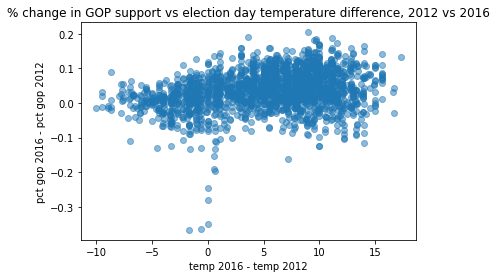

In [4]:
# Query the database
# Uses data from 2 sources
q = cur.execute('SELECT temp_12,temp_16,pct_gop_2012,pct_gop_2016 '\
                'FROM weather '\
                'JOIN votes '\
                'ON weather.fips = votes.fips '\
                'WHERE temp_12 IS NOT null and '\
                      'temp_16 IS NOT null and '\
                      'pct_gop_2012 IS NOT null and '\
                      'pct_gop_2016 IS NOT null')

x = [] # The change in temperature on election day, 2016 minus 2012
y = [] # The change in the percent support for the GOP candidate, 2016 minus 2012
count = 0
for row in q:
    x.append(row[1]-row[0])
    y.append(row[3]-row[2])

# Define the graph
plt.scatter(x, y, alpha=0.5)
plt.title('% change in GOP support vs election day temperature difference, 2012 vs 2016')
plt.xlabel('temp 2016 - temp 2012')
plt.ylabel('pct gop 2016 - pct gop 2012')
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

The following examines partisan voting differences from 2012 to 2016 vs house value trends. The x-axis is the average annual percent change in median house value, and the y-axis is the difference in percent vote for the GOP candidate (2016-2012).

/home/chris/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


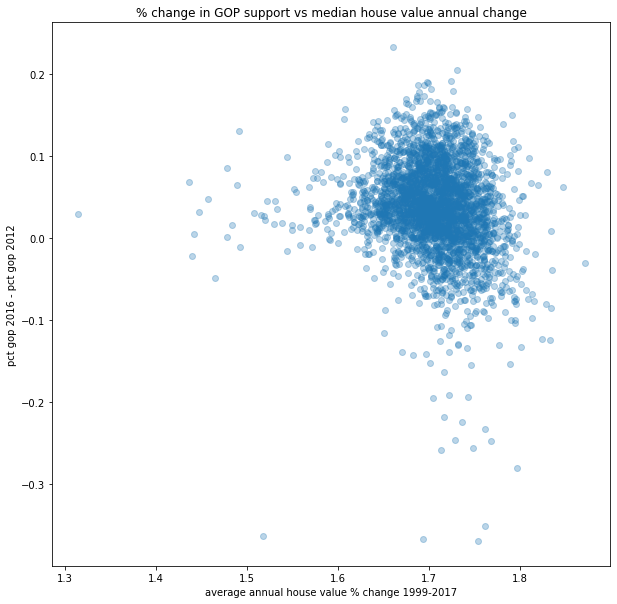

In [5]:
# Query the database
# Uses data from 2 sources
q = cur.execute('SELECT median_house_inc_val_usd,median_house_inc_ref_val_usd,'\
                       'pct_gop_2012,pct_gop_2016,median_house_inc_yr,'\
                       'median_house_inc_ref_yr '\
                'FROM citydata '\
                'JOIN votes '\
                'ON citydata.fips = votes.fips '\
                'WHERE median_house_inc_val_usd IS NOT null and '\
                      'median_house_inc_ref_val_usd IS NOT null and '\
                      'pct_gop_2012 IS NOT null and '\
                      'pct_gop_2016 IS NOT null')

x = [] # The average annual percent change in house value from 1999 to 2017
y = [] # The change in the percent support for the GOP candidate, 2016 minus 2012
count = 0
for row in q:
    x.append((row[0]-row[1])**(1/(row[4]-row[5])))
    y.append(row[3]-row[2])

# Define the graph
plt.scatter(x, y, alpha=0.3)
plt.title('% change in GOP support vs median house value annual change')
plt.xlabel('average annual house value % change 1999-2017')
plt.ylabel('pct gop 2016 - pct gop 2012')
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

The following histogram shows the county-level counts of shift in percentage of GOP voters from 2012 to 2016. So, for example, a county falls in the [0.05,0.1] bucket if the fraction of voters who voted GOP in 2016 minus the fraction of voters who voted GOP in 2012 is between 5% and 10%.

(0.0, 10.0)

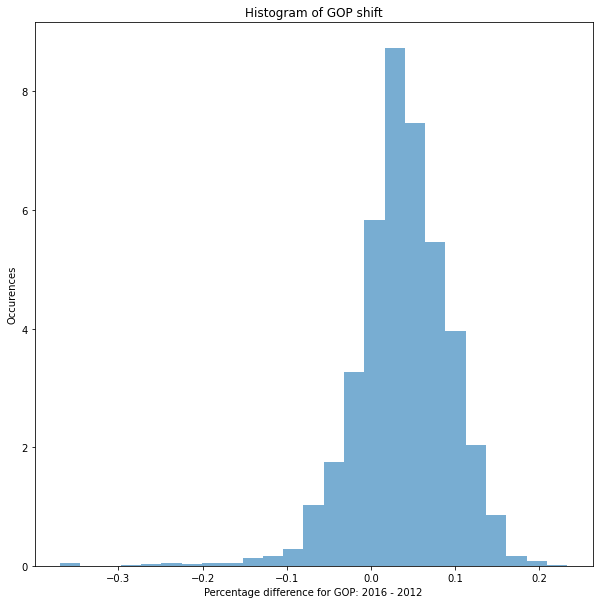

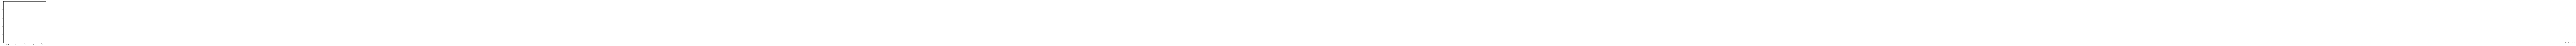

In [6]:
# Query the database
q = cur.execute('SELECT pct_gop_2012, pct_gop_2016 '\
                'FROM votes '\
                'WHERE pct_gop_2012 IS NOT null and '\
                      'pct_gop_2012 IS NOT null')

x=[] # The shift in percentage of vote for the gop, 2016 minus 2012
for i,j in q:
    x.append(j-i)
n, bins, patches = plt.hist(x, 25, density=True, alpha=0.6)

# Define the plot
plt.xlabel('Percentage difference for GOP: 2016 - 2012')
plt.ylabel('Occurences')
plt.title('Histogram of GOP shift')
plt.figure(figsize=(6,6))
plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.xlim(-0.5, 0.5)
plt.ylim(0, 10)

This plot shows the shift in the percentage of gop vote by state, again 2016 minus 2012.

/home/chris/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<BarContainer object of 51 artists>

<Figure size 720x720 with 0 Axes>

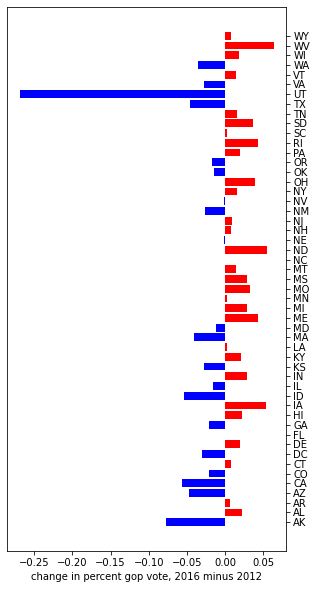

In [7]:
# Query the database
q = cur.execute('SELECT count(*),state_abbr,SUM(votes_gop_2012),SUM(total_votes_2012),'\
                       'SUM(votes_gop_2016),SUM(total_votes_2016) '\
                'FROM votes '\
                'GROUP BY state_abbr')

# Extract the state and vote information from the query
states = []
for n,a,b,c,d,e in q:
    states.append({'state':a,'votes_gop_2012':b,'total_votes_2012':c,
                   'votes_gop_2016':d,'total_votes_2016':e})

# Form a database from the states dict list
df = pd.DataFrame(states)

# Define the shift column, which will become the bar length, left = negative
df['shift'] = df.votes_gop_2016/df.total_votes_2016-df.votes_gop_2012/df.total_votes_2012

# I need to split the shift vector into positive and negative pieces
pos=[]
for val in df['shift']:
    if val<0: pos.append(0)
    else: pos.append(val)
neg = []
for val in df['shift']:
    if val>=0: neg.append(0)
    else: neg.append(val)

# Define the plot    
x = range(len(df))
fig = plt.figure()
plt.figure(figsize=(5,10))
plt.xlabel('change in percent gop vote, 2016 minus 2012')
ax = plt.subplot(111)
ax.set_yticks(np.arange(51))
ax.set_yticklabels(df.state.values)
ax.yaxis.tick_right()
ax.barh(x, neg, color='b')
ax.barh(x, pos, color='r')


This plot shows the percent change in GOP voters from 2012 to 2016 vs the percent change in birth rate from the interval [1990,1999] to [2000,2006].

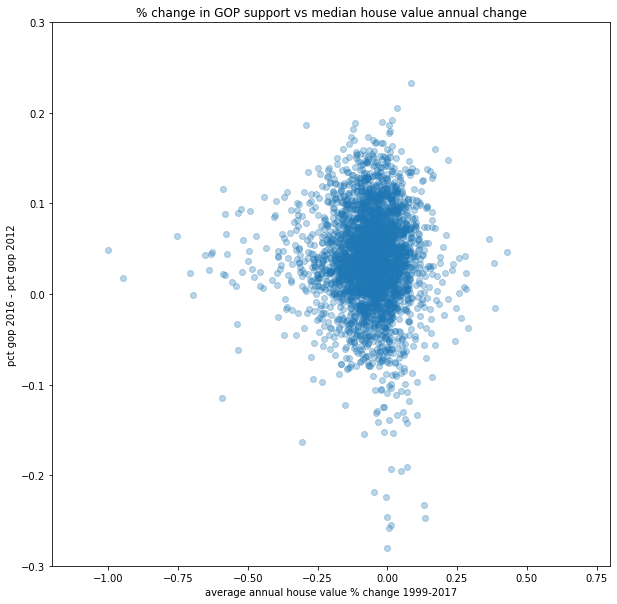

In [8]:
# Query the database
# Uses data from 2 sources
q = cur.execute('SELECT birth_per_1000_int1,birth_per_1000_int2,pct_gop_2012,pct_gop_2016 '\
                'FROM citydata '\
                'JOIN votes '\
                'ON citydata.fips = votes.fips '\
                'WHERE birth_per_1000_int1 IS NOT null and '\
                      'birth_per_1000_int2 IS NOT null and '\
                      'pct_gop_2012 IS NOT null and '\
                      'pct_gop_2016 IS NOT null')

x = [] # Change in birth rate from [1990,1999] to [2000,2006]
y = [] # The change in the percent support for the GOP candidate, 2016 minus 2012
count = 0
for row in q:
    x.append((row[1]-row[0])/row[1])
    y.append(row[3]-row[2])

# Define the plot
plt.scatter(x, y, alpha=0.3)
plt.xlim(-1.2, 0.8)
plt.ylim(-0.3, 0.3)
plt.title('% change in GOP support vs median house value annual change')
plt.xlabel('average annual house value % change 1999-2017')
plt.ylabel('pct gop 2016 - pct gop 2012')
plt.rcParams["figure.figsize"] = (20,15)
plt.show()

This plot shows fair market rent for a 2 bedroom apartment vs median income. The counties are color-coded by average temperature on the two election days with blue being the coldest third, orange being the middle third, and red being the warmest third.  

In [9]:
# Query the database
q = cur.execute('SELECT temp_12, temp_16, rent_2br_usd,median_house_inc_ref_val_usd '\
                'FROM weather '\
                'JOIN citydata '\
                'ON weather.fips = citydata.fips '\
                'WHERE temp_16 IS NOT null and '\
                'rent_2br_usd IS NOT null and '\
                'median_house_inc_val_usd IS NOT null')

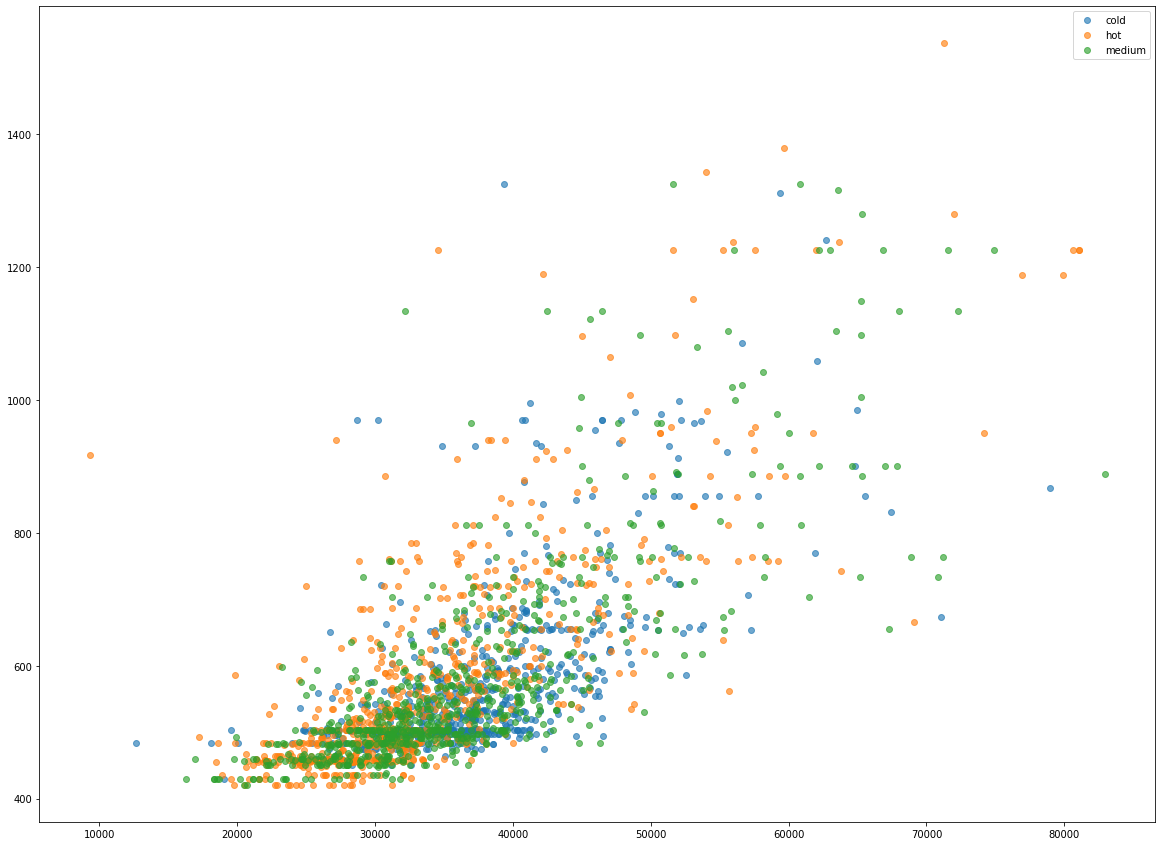

In [10]:
# Query the database
q = cur.execute('SELECT temp_16, rent_2br_usd,median_house_inc_ref_val_usd '\
                'FROM weather '\
                'JOIN citydata '\
                'ON weather.fips = citydata.fips '\
                'WHERE temp_16 IS NOT null and '\
                'rent_2br_usd IS NOT null and '\
                'median_house_inc_val_usd IS NOT null')

# Initialize temp, income, and rent vectors
temps = [] # temperatures
x = [] # median incomes
y = [] # 2bd rent
for row in q:
    temps.append(row[0])
    x.append(row[2])
    y.append(row[1])


# Find the temperature cutoffs for cold/medium/hot
tempsort = [temp for temp in temps]
tempsort.sort()
third =int(len(tempsort)/3)
cold_cutoff = tempsort[third]
hot_cutoff = tempsort[2*third]

# A function to label the temperatures according to cold/hot cutoffs
def set_label(temp):
    if temp < cold_cutoff:
        return('cold')
    elif temp < hot_cutoff:
        return('medium')
    else:
        return('hot')

# Call the labels function on the temp vector
labels = [set_label(temp) for temp in temps]
df = pd.DataFrame(dict(inc=x, rent_2b=y, label=labels))

# Define the groups for the plot
groups = df.groupby('label')

# Define the plot
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.inc, group.rent_2b, marker='o', linestyle='', ms=6, label=name, alpha = 0.64)
ax.legend()

plt.show()